# MCMC: Metropolis-Hastings algorithm and diagnostics

Florent Leclercq,<br/>
Institut d'Astrophysique de Paris,<br/>
florent.leclercq@iap.fr

In [1]:
import numpy as np
from scipy.stats import norm, binom, beta, multivariate_normal
from matplotlib import pyplot as plt
from scipy.integrate import quad
from cycler import cycler
from matplotlib.ticker import NullFormatter
np.random.seed(123456)

In [2]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 15})
dir="./plots/MCMC_MH/"
!mkdir -p $dir

## One-dimensional Metropolis-Hastings algorithm

In this section, we consider a Bernoulli experiment (a series of $N_{\mathrm{trials}}$ independent experiments, each with its own boolean-valued outcome). The target parameter is the success rate $\theta$. The likelihood for this problem is a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) and the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) provides a family of conjuguate priors for Bayesian inference.

### Generate data

In [3]:
groundtruth = 0.38
Ntrials = 100
Nsuccesses = binom(Ntrials, groundtruth).rvs()
Nsuccesses

33

### Analytic solution

If the likelihood is a binomial distribution with $N_{\mathrm{successes}}$ for $N_{\mathrm{trials}}$, and if the prior is a beta distribution with parameters ($\alpha$, $\beta$), then the posterior is a beta distribution with parameters
\begin{equation}
\alpha' = \alpha+N_{\mathrm{successes}}, \quad \beta' = \beta + N_{\mathrm{trials}} - N_{\mathrm{successes}}
\end{equation}
(see for example https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_discrete_distribution).

In [4]:
def target_pdf(theta,Ntrials,Nsuccesses,lh,prior):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lh(Ntrials,theta).pmf(Nsuccesses)*prior.pdf(theta)

def target_logpdf(theta,Ntrials,Nsuccesses,lh,prior):
    if theta < 0 or theta > 1:
        return -np.inf
    else:
        return lh(Ntrials,theta).logpmf(Nsuccesses)+prior.logpdf(theta)

In [5]:
a = 10
b = 10
lh = binom
prior = beta(a,b)
posterior = beta(a+Nsuccesses, b+Ntrials-Nsuccesses)

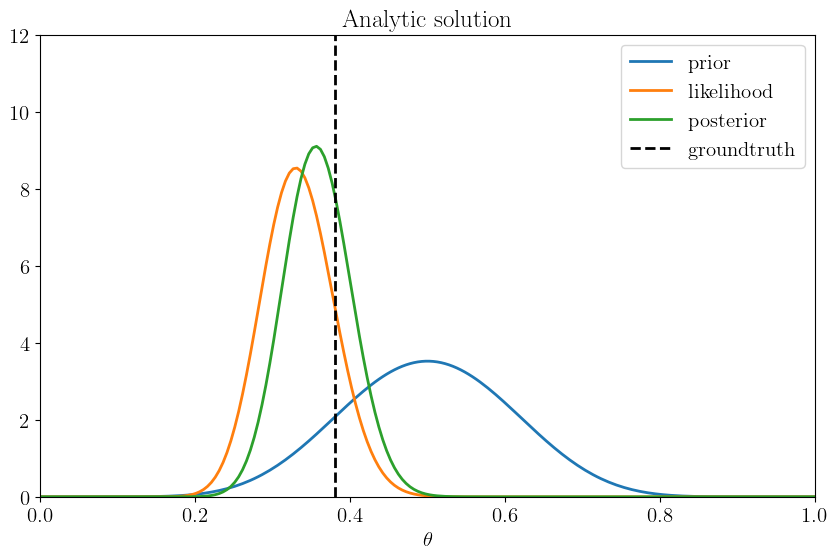

In [6]:
thetas = np.linspace(0, 1, 200)
plt.figure(figsize=(10,6))
plt.xlim([0,1])
plt.ylim([0,12])
plt.xlabel("$\\theta$")
plt.plot(thetas, prior.pdf(thetas)/quad(prior.pdf,0,1)[0], label="prior")
plt.plot(thetas, lh(Ntrials,thetas).pmf(Nsuccesses)/quad(lambda theta: lh(Ntrials, theta).pmf(Nsuccesses),0,1)[0], label="likelihood")
plt.plot(thetas, posterior.pdf(thetas)/quad(posterior.pdf,0,1)[0], label="posterior")
plt.axvline(groundtruth,color='black',linestyle='--',label="groundtruth")
plt.title("Analytic solution")
plt.legend(loc='best')
plt.savefig(dir+'MH_1D_analytic_solution.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'MH_1D_analytic_solution.png',dpi=300,bbox_inches="tight")
plt.show()

### Metropolis-Hastings sampler

In [7]:
def proposal_pdf(sigma):
    return norm(0,sigma)

In [8]:
def MH_sampler(Ntries,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma):
    Naccepted=0
    samples=np.zeros(Ntries+1)
    samples[0]=theta_start
    theta=theta_start
    for i in range(Ntries):
        theta_p = theta + proposal_pdf(proposal_sigma).rvs()
        # the Gaussian proposal pdf satisfies the detailed balance equation, so the
        # acceptance ratio simplifies to the Metropolis ratio
        # for numerical reasons, it is better to use the log of the ratio
        log_a = min(0, target_logpdf(theta_p,Ntrials,Nsuccesses,lh,prior) - target_logpdf(theta,Ntrials,Nsuccesses,lh,prior))
        u = np.random.uniform()
        if np.log(u) < log_a:
            Naccepted+=1
            theta=theta_p
        samples[i+1] = theta
    return Naccepted, samples

In [9]:
Ntries1=2000
Ntrace=1000
Nburnin=50
proposal_sigma=0.1
theta_start=0.6
Naccepted, samples = MH_sampler(Ntries1,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma)
fraction_accepted=float(Naccepted)/Ntries1

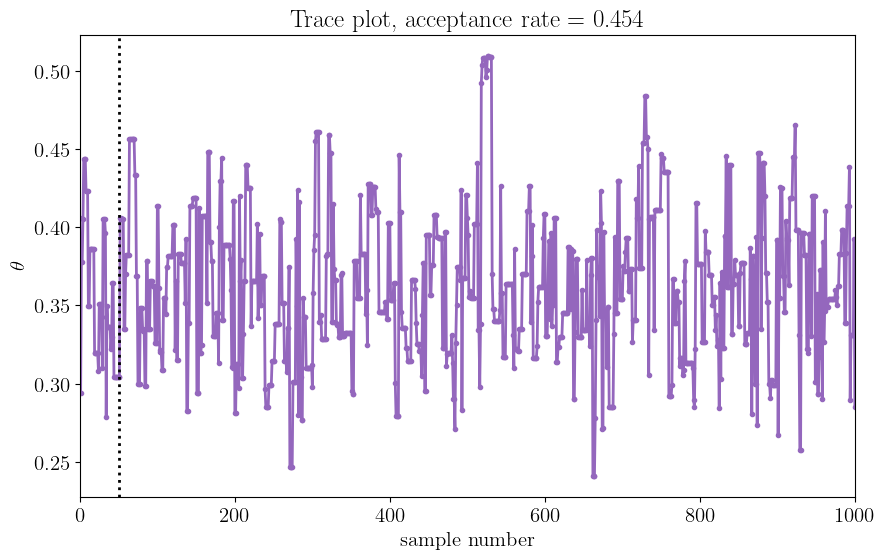

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim(0,Ntrace)
ax.set_xlabel("sample number")
ax.set_ylabel("$\\theta$")
ax.set_title("Trace plot, acceptance rate = {:.3f}".format(fraction_accepted))
ax.plot(np.arange(Ntrace+1),samples[Ntrace:],marker='.',color='C4')
ax.axvline(Nburnin,color='black',linestyle=':')
plt.savefig(dir+'MH_1D_trace_plot.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'MH_1D_trace_plot.png',dpi=300,bbox_inches="tight")
plt.show()

In [11]:
fraction_accepted

0.4535

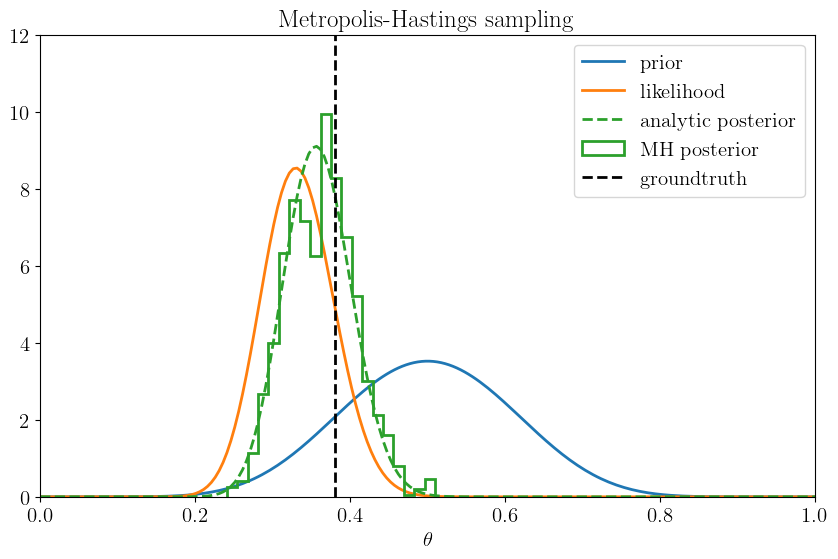

In [12]:
burnedin_samples=samples[Nburnin:]
plt.figure(figsize=(10,6))
plt.xlim([0,1])
plt.ylim([0,12])
plt.xlabel("$\\theta$")
plt.plot(thetas, prior.pdf(thetas), label="prior")
plt.plot(thetas, lh(Ntrials,thetas).pmf(Nsuccesses)/quad(lambda theta: lh(Ntrials, theta).pmf(Nsuccesses),0,1)[0], label="likelihood")
plt.plot(thetas, posterior.pdf(thetas), color='C2', linestyle='--', label="analytic posterior")
plt.hist(burnedin_samples, 20, histtype='step', density=True, color='C2', linewidth=2, label="MH posterior")
plt.axvline(groundtruth,color='black',linestyle='--',label="groundtruth")
plt.title("Metropolis-Hastings sampling")
plt.legend(loc='best')
plt.savefig(dir+'MH_1D_posterior.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'MH_1D_posterior.png',dpi=300,bbox_inches="tight")
plt.show()

### Markov Chain diagnostics

#### 1- Step size

In [13]:
Ntries2=1000
theta_start=0.6

In [14]:
# Suitable step size
proposal_sigma_1=0.1
Naccepted_1, samples_1 = MH_sampler(Ntries2,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma_1)
fraction_accepted_1=float(Naccepted_1)/Ntries2

In [15]:
# Step size too large
proposal_sigma_2=4
Naccepted_2, samples_2 = MH_sampler(Ntries2,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma_2)
fraction_accepted_2=float(Naccepted_2)/Ntries2

In [16]:
# Step size too small
proposal_sigma_3=0.003
Naccepted_3, samples_3 = MH_sampler(Ntries2,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma_3)
fraction_accepted_3=float(Naccepted_3)/Ntries2

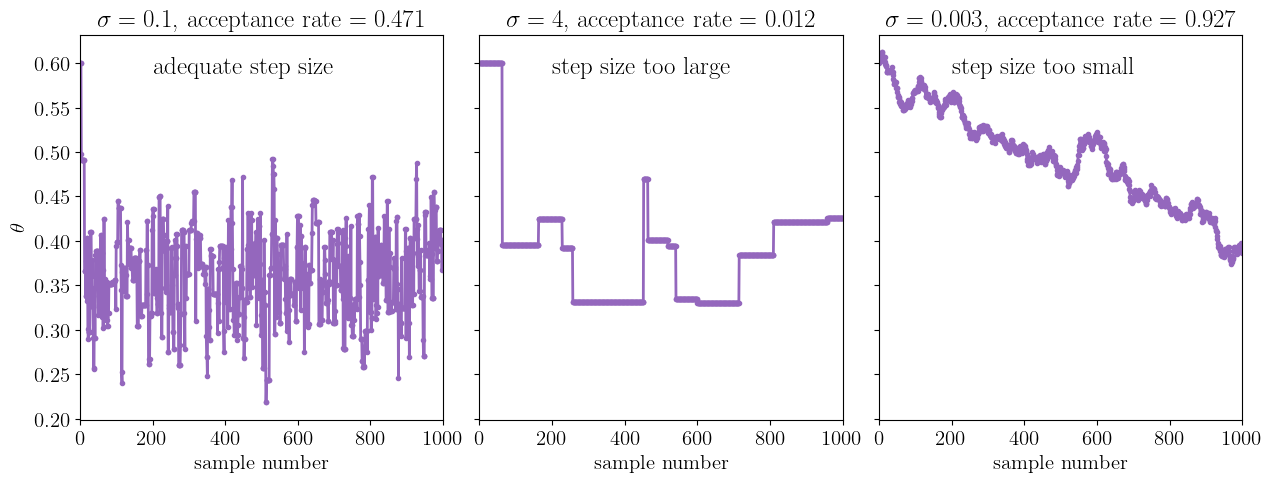

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.set_xlim(0,Ntries2)
ax1.set_xlabel("sample number")
ax1.set_ylabel("$\\theta$")
ax1.plot(np.arange(Ntries2+1),samples_1,marker='.',color='C4')
ax1.set_title("$\sigma={}$, acceptance rate = {:.3f}".format(proposal_sigma_1,fraction_accepted_1))
ax2.set_xlim(0,Ntries2)
ax2.set_xlabel("sample number")
ax2.plot(np.arange(Ntries2+1),samples_2,marker='.',color='C4')
ax2.set_title("$\sigma={}$, acceptance rate = {:.3f}".format(proposal_sigma_2,fraction_accepted_2))
ax3.set_xlim(0,Ntries2)
ax3.set_xlabel("sample number")
ax3.plot(np.arange(Ntries2+1),samples_3,marker='.',color='C4')
ax3.set_title("$\sigma={}$, acceptance rate = {:.3f}".format(proposal_sigma_3,fraction_accepted_3))
ymin, ymax = ax1.get_ylim()
ax1.text(200,ymax-(ymax-ymin)/10., "adequate step size",fontsize=18)
ax2.text(200,ymax-(ymax-ymin)/10., "step size too large",fontsize=18)
ax3.text(200,ymax-(ymax-ymin)/10., "step size too small",fontsize=18)
f.subplots_adjust(wspace=0.1)
plt.savefig(dir+'MH_1D_trace_plot_step_size_tuning.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'MH_1D_trace_plot_step_size_tuning.png',dpi=300,bbox_inches="tight")
plt.show()

#### 2- Multiple chains, different starting point

In [18]:
Ntries3=100
proposal_sigma=0.05
Nchains=5
Nburnin=20

In [19]:
# Run Nchains different chains starting at different positions in parameter space
chains = [MH_sampler(Ntries3,theta_start,Ntrials,Nsuccesses,lh,prior,proposal_sigma)
          for theta_start in np.linspace(0.1,0.9,Nchains)]

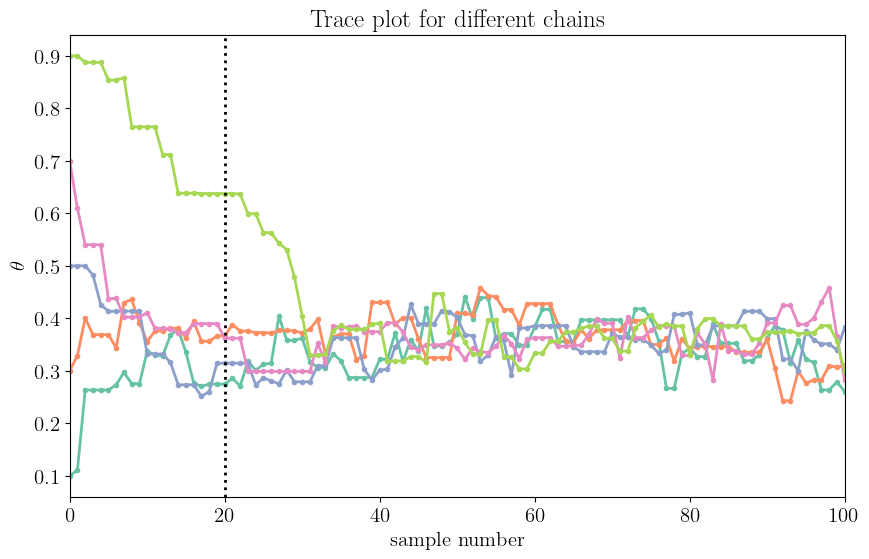

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim(0,Ntries3)
ax.set_xlabel("sample number")
ax.set_ylabel("$\\theta$")
ax.set_prop_cycle(cycler('color', [plt.cm.Set2(i) for i in np.linspace(0, 1, 8)]))
for samples in chains:
    ax.plot(np.arange(Ntries3+1),samples[1],marker='.')
ax.axvline(Nburnin,color='black',linestyle=':')
plt.title("Trace plot for different chains")
plt.savefig(dir+'MH_1D_trace_plot_different_starting_points.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'MH_1D_trace_plot_different_starting_points.png',dpi=300,bbox_inches="tight")
plt.show()

#### 3- Gelman-Rubin test

Gelman *et al.*, "*Bayesian Data Analysis*" (third edition), p. 284-285

**Parameters**:
* $m$: number of chains
* $n$: length of chains

**Definitions**:
* "between" chains variance:
\begin{equation}
B \equiv \frac{n}{m-1} \sum_{j=1}^m \left( \bar{\psi}_{. j} - \bar{\psi}_{..} \right)^2 \quad \mathrm{where} \quad \bar{\psi}_{. j} = \frac{1}{n} \sum_{i=1}^n \psi_{ij} \quad \mathrm{and} \quad \bar{\psi}_{..} = \frac{1}{m} \sum_{j=1}^m \bar{\psi}_{.j}
\end{equation}
* "within" chains variance:
\begin{equation}
W \equiv \frac{1}{m} \sum_{j=1}^m s_j^2 \quad \mathrm{where} \quad s_j^2 = \frac{1}{n-1} \sum_{i=1}^n \left( \psi_{ij} - \bar{\psi}_{.j} \right)^2
\end{equation}

**Estimators**:
Estimators of the marginal posterior variance of the estimand:
* $\widehat{\mathrm{var}}^- \equiv W$: underestimates the variance
* $\widehat{\mathrm{var}}^+ \equiv \frac{n}{n-1}W + \frac{1}{n} B$: overestimates the variance

**Test**:
* Potential scale reduction factor: $\widehat{R} \equiv \sqrt{\frac{\widehat{\mathrm{var}}^+}{\widehat{\mathrm{var}}^-}}$
* Test: $\widehat{R} \rightarrow 1$ as $n \rightarrow \infty$

In [21]:
psi_j = np.array([np.mean(chains[j][1]) for j in range(Nchains)])
psi = np.mean(psi_j)
B = float(Nchains)/(Ntries3-1)*np.sum((psi_j-psi*np.ones(Nchains))**2)
B

0.0005243864838748328

In [22]:
s_j = np.array([1./(Ntries3-1)*np.sum((chains[j][1]-psi_j[j])**2) for j in range(Nchains)])
W = np.mean(s_j)
W

0.008361513718283262

In [23]:
var_minus=W
var_plus=float(Ntries3)/(Ntries3-1)*W+1./Ntries3*B
var_minus, var_plus

(0.008361513718283262, 0.008451217317650124)

In [24]:
R=np.sqrt(var_plus/var_minus)
R

1.0053497665518722

## Two-dimensional Metropolis-Hastings algorithm

### The target pdf

In [25]:
def target_joint_pdf(x,y):
    return x*x * np.exp(-x*y*y -y*y +2.*y -4.*x)

def target_joint_logpdf(x,y):
    if x < 0:
        return -np.inf
    else:
        return 2.*np.log(x) - x*y*y - y*y + 2.*y - 4.*x

In [26]:
xmin=0.
xmax=2.
ymin=-1.
ymax=2.5
x=np.linspace(xmin,xmax,1000)
y=np.linspace(ymin,ymax,1000)
X,Y=np.meshgrid(x,y)
Z=target_joint_pdf(X,Y)

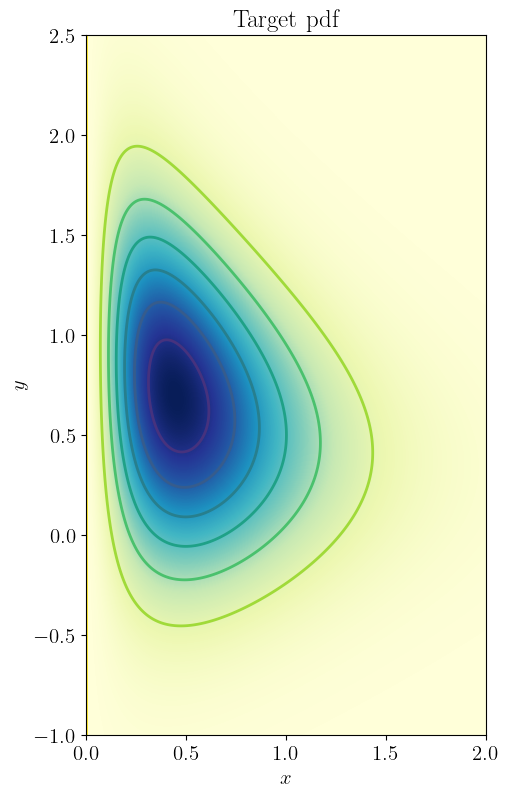

In [27]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0., xmax-xmin
bottom, height = 0., ymax-ymin
rect_pdf = [left, bottom, width, height]

plt.figure(1, figsize=(2, 2))
ax = plt.axes(rect_pdf)

# the 2D plot:
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.imshow(Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='YlGnBu')
ax.contour(X,Y,Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='viridis_r')

ax.set_title("Target pdf")
plt.savefig(dir+'MH_2D_target_pdf.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'MH_2D_target_pdf.png',dpi=300,bbox_inches="tight")
plt.show()

### Metropolis-Hastings sampler

In [28]:
def proposal_joint_pdf(sigma_x,sigma_y):
    return multivariate_normal(mean=[0,0], cov=[[sigma_x**2, 0], [0, sigma_y**2]])

In [29]:
def MH_sampler_2D(Ntries,theta_start,target_joint_logpdf,sigma_x,sigma_y):
    Naccepted=0
    samples=np.zeros((Ntries+1,2))
    samples[0]=theta_start
    theta=theta_start
    for i in range(Ntries):
        theta_p = theta + proposal_joint_pdf(sigma_x,sigma_y).rvs()
        # the Gaussian proposal pdf satisfies the detailed balance equation, so the
        # acceptance ratio simplifies to the Metropolis ratio
        # for numerical reasons, it is better to use the log of the ratio
        log_a = min(0, target_joint_logpdf(theta_p[0],theta_p[1]) - target_joint_logpdf(theta[0],theta[1]))
        u = np.random.uniform()
        if np.log(u) < log_a:
            Naccepted+=1
            theta=theta_p
        samples[i+1] = theta
    return Naccepted, samples

In [30]:
Ntries1=1000
Nburnin=50
sigma_x, sigma_y=0.5, 0.5
theta_start=np.array([1.5,2.0])
Naccepted, samples = MH_sampler_2D(Ntries1,theta_start,target_joint_logpdf,sigma_x,sigma_y)
fraction_accepted=float(Naccepted)/Ntries1

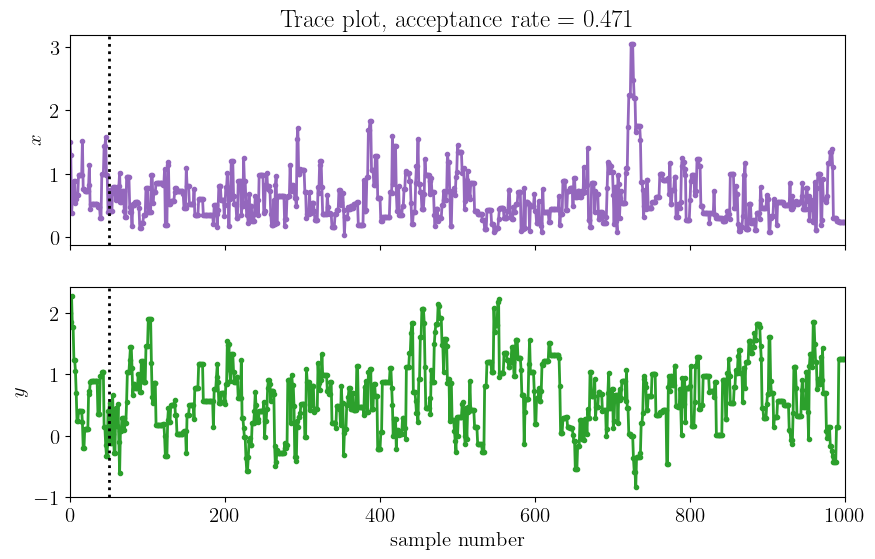

In [31]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
ax0.set_ylabel("$x$")
ax0.set_title("Trace plot, acceptance rate = {:.3f}".format(fraction_accepted))
ax0.plot(np.arange(Ntries1+1),samples.T[0],marker='.',color='C4')
ax0.axvline(Nburnin,color='black',linestyle=':')
ax1.set_xlim(0,Ntries1)
ax1.set_xlabel("sample number")
ax1.set_ylabel("$y$")
ax1.plot(np.arange(Ntries1+1),samples.T[1],marker='.',color='C2')
ax1.axvline(Nburnin,color='black',linestyle=':')
plt.savefig(dir+'MH_2D_trace_plot.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'MH_2D_trace_plot.png',dpi=300,bbox_inches="tight")
plt.show()

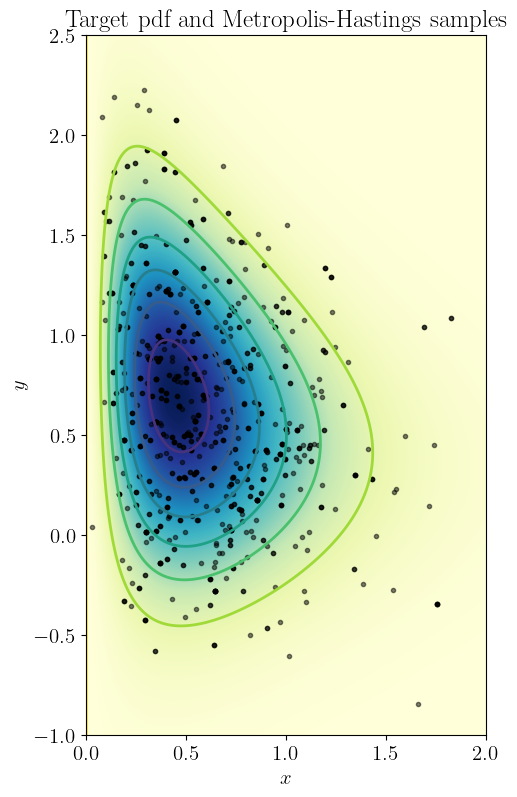

In [32]:
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0., xmax-xmin
bottom, height = 0., ymax-ymin
rect_pdf = [left, bottom, width, height]

plt.figure(1, figsize=(2, 2))
ax = plt.axes(rect_pdf)

# the 2D plot:
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.imshow(Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='YlGnBu')
ax.scatter(samples[Nburnin:,0], samples[Nburnin:,1], marker='.', color='black', alpha=0.5)
ax.contour(X,Y,Z,extent=(xmin,xmax,ymin,ymax),origin='lower',cmap='viridis_r')

ax.set_title("Target pdf and Metropolis-Hastings samples")
plt.savefig(dir+'MH_2D_target_pdf_and_samples.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'MH_2D_target_pdf_and_samples.png',dpi=300,bbox_inches="tight")
plt.show()

### Markov Chain diagnostics

#### 1- Step size

In [33]:
Ntries2=1000
theta_start=np.array([1.5,2.0])

In [34]:
# Suitable step size
sigma1_x,sigma1_y=0.5, 0.5
Naccepted_1, samples_1 = MH_sampler_2D(Ntries2,theta_start,target_joint_logpdf,sigma1_x,sigma1_y)
fraction_accepted_1=float(Naccepted_1)/Ntries2

In [35]:
# Step size too large
sigma2_x,sigma2_y=5, 5
Naccepted_2, samples_2 = MH_sampler_2D(Ntries2,theta_start,target_joint_logpdf,sigma2_x,sigma2_y)
fraction_accepted_2=float(Naccepted_2)/Ntries2

In [36]:
# Step size too small
sigma3_x,sigma3_y=0.03, 0.03
Naccepted_3, samples_3 = MH_sampler_2D(Ntries2,theta_start,target_joint_logpdf,sigma3_x,sigma3_y)
fraction_accepted_3=float(Naccepted_3)/Ntries2

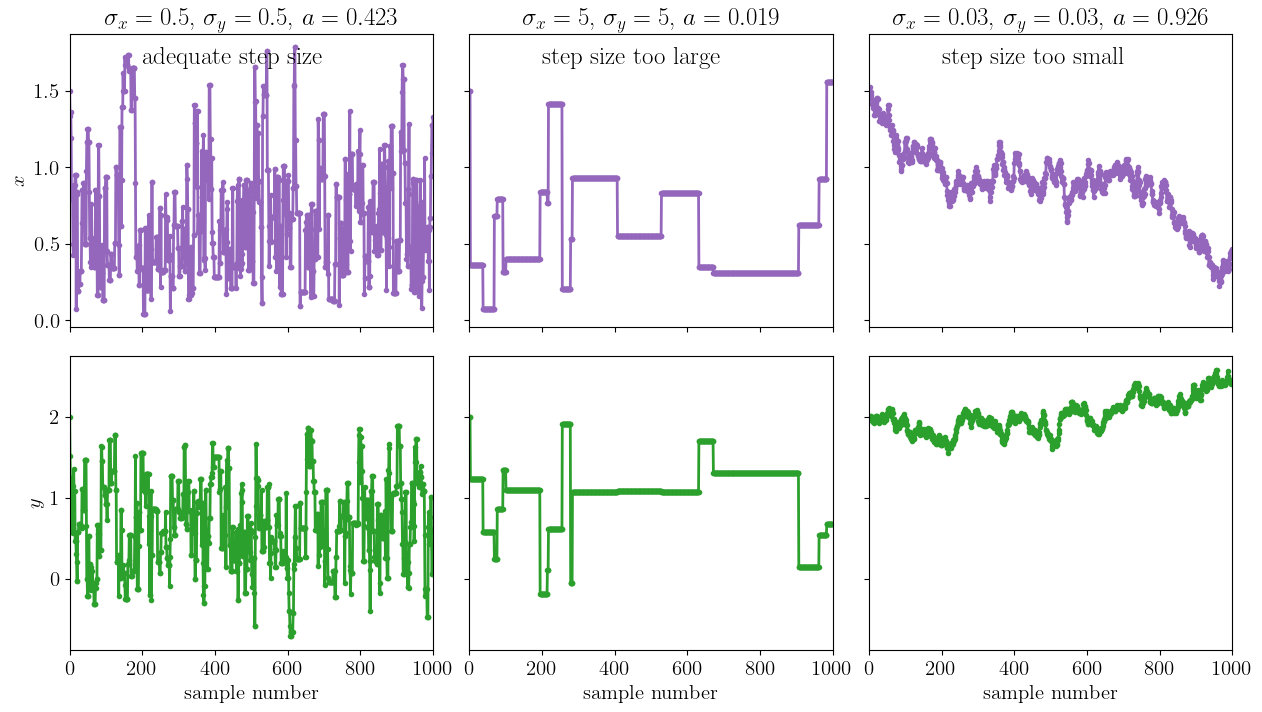

In [37]:
f, ((ax1a, ax2a, ax3a), (ax1b, ax2b, ax3b)) = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,8))
ax1a.set_ylabel("$x$")
ax1a.plot(np.arange(Ntries2+1),samples_1.T[0],marker='.',color='C4')
ax1a.set_title("$\sigma_x={}$, $\sigma_y={}$, $a={:.3f}$".format(sigma1_x,sigma1_y,fraction_accepted_1))
ax2a.plot(np.arange(Ntries2+1),samples_2.T[0],marker='.',color='C4')
ax2a.set_title("$\sigma_x={}$, $\sigma_y={}$, $a={:.3f}$".format(sigma2_x,sigma2_y,fraction_accepted_2))
ax3a.plot(np.arange(Ntries2+1),samples_3.T[0],marker='.',color='C4')
ax3a.set_title("$\sigma_x={}$, $\sigma_y={}$, $a={:.3f}$".format(sigma3_x,sigma3_y,fraction_accepted_3))
ymin, ymax = ax1a.get_ylim()
ax1a.text(200,ymax-(ymax-ymin)/10., "adequate step size",fontsize=18)
ax2a.text(200,ymax-(ymax-ymin)/10., "step size too large",fontsize=18)
ax3a.text(200,ymax-(ymax-ymin)/10., "step size too small",fontsize=18)
ax1b.set_xlim(0,Ntries2)
ax1b.set_xlabel("sample number")
ax1b.set_ylabel("$y$")
ax1b.plot(np.arange(Ntries2+1),samples_1.T[1],marker='.',color='C2')
ax2b.set_xlim(0,Ntries2)
ax2b.set_xlabel("sample number")
ax2b.plot(np.arange(Ntries2+1),samples_2.T[1],marker='.',color='C2')
ax3b.set_xlim(0,Ntries2)
ax3b.set_xlabel("sample number")
ax3b.plot(np.arange(Ntries2+1),samples_3.T[1],marker='.',color='C2')

f.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig(dir+'MH_2D_trace_plot_step_size_tuning_1.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'MH_2D_trace_plot_step_size_tuning_1.png',dpi=300,bbox_inches="tight")
plt.show()

In [38]:
# sigma_x large, sigma_y adequate
sigma4_x,sigma4_y=20, 0.5
N_accepted_4, samples_4 = MH_sampler_2D(Ntries2,theta_start,target_joint_logpdf,sigma4_x,sigma4_y)
fraction_accepted_4=float(N_accepted_4)/Ntries2

In [39]:
# sigma_x adequate, sigma_y small
sigma5_x,sigma5_y=0.5, 0.03
N_accepted_5, samples_5 = MH_sampler_2D(Ntries2,theta_start,target_joint_logpdf,sigma5_x,sigma5_y)
fraction_accepted_5=float(N_accepted_5)/Ntries2

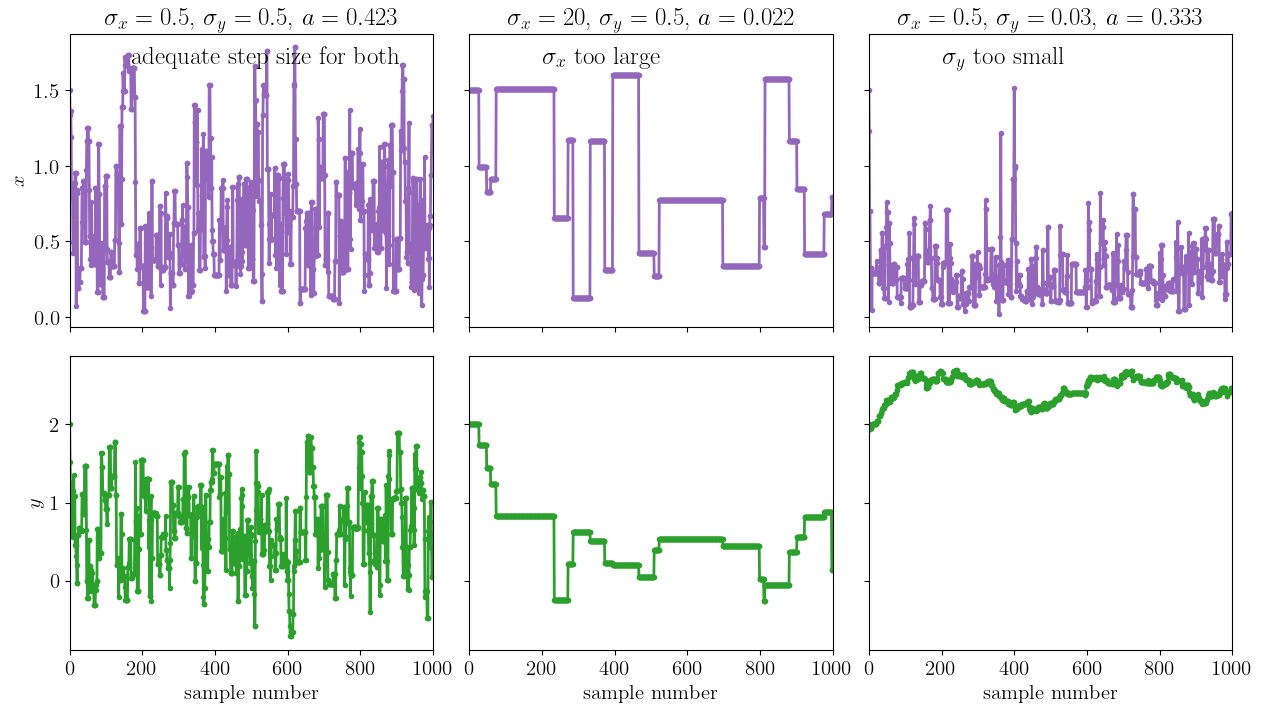

In [40]:
f, ((ax1a, ax2a, ax3a), (ax1b, ax2b, ax3b)) = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15,8))
ax1a.set_ylabel("$x$")
ax1a.plot(np.arange(Ntries2+1),samples_1.T[0],marker='.',color='C4')
ax1a.set_title("$\sigma_x={}$, $\sigma_y={}$, $a={:.3f}$".format(sigma1_x,sigma1_y,fraction_accepted_1))
ax2a.plot(np.arange(Ntries2+1),samples_4.T[0],marker='.',color='C4')
ax2a.set_title("$\sigma_x={}$, $\sigma_y={}$, $a={:.3f}$".format(sigma4_x,sigma4_y,fraction_accepted_4))
ax3a.plot(np.arange(Ntries2+1),samples_5.T[0],marker='.',color='C4')
ax3a.set_title("$\sigma_x={}$, $\sigma_y={}$, $a={:.3f}$".format(sigma5_x,sigma5_y,fraction_accepted_5))
ymin, ymax = ax1a.get_ylim()
ax1a.text(170,ymax-(ymax-ymin)/10., "adequate step size for both",fontsize=18)
ax2a.text(200,ymax-(ymax-ymin)/10., "$\sigma_x$ too large",fontsize=18)
ax3a.text(200,ymax-(ymax-ymin)/10., "$\sigma_y$ too small",fontsize=18)
ax1b.set_xlim(0,Ntries2)
ax1b.set_xlabel("sample number")
ax1b.set_ylabel("$y$")
ax1b.plot(np.arange(Ntries2+1),samples_1.T[1],marker='.',color='C2')
ax2b.set_xlim(0,Ntries2)
ax2b.set_xlabel("sample number")
ax2b.plot(np.arange(Ntries2+1),samples_4.T[1],marker='.',color='C2')
ax3b.set_xlim(0,Ntries2)
ax3b.set_xlabel("sample number")
ax3b.plot(np.arange(Ntries2+1),samples_5.T[1],marker='.',color='C2')

f.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig(dir+'MH_2D_trace_plot_step_size_tuning_2.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'MH_2D_trace_plot_step_size_tuning_2.png',dpi=300,bbox_inches="tight")
plt.show()

#### 2- Multiple chains, different starting point

In [41]:
Ntries3=500
sigma_x,sigma_y=0.5, 0.5
Nchains=5
Nburnin=10

In [42]:
# Run Nchains different chains starting at different positions in parameter space
chains = [MH_sampler_2D(Ntries3,theta_start,target_joint_logpdf,sigma_x,sigma_y)
          for theta_start in np.column_stack((np.linspace(0.1,0.9,Nchains),np.linspace(0.1,0.9,Nchains)))]
chains = np.array([chain[1] for chain in chains])

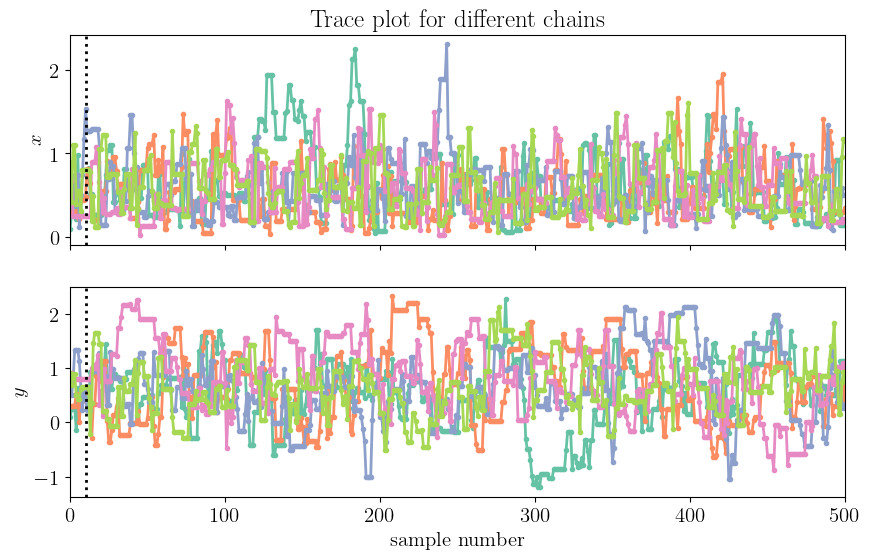

In [43]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
ax0.set_prop_cycle(cycler('color', [plt.cm.Set2(i) for i in np.linspace(0, 1, 8)]))
ax1.set_prop_cycle(cycler('color', [plt.cm.Set2(i) for i in np.linspace(0, 1, 8)]))
ax0.set_ylabel("$x$")
ax0.set_title("Trace plot for different chains")
for c in range(Nchains):
    ax0.plot(np.arange(Ntries3+1),chains[c].T[0],marker='.')
ax0.axvline(Nburnin,color='black',linestyle=':')
ax1.set_xlim(0,Ntries3)
ax1.set_xlabel("sample number")
ax1.set_ylabel("$y$")
for c in range(Nchains):
    ax1.plot(np.arange(Ntries3+1),chains[c].T[1],marker='.')
ax1.axvline(Nburnin,color='black',linestyle=':')
plt.savefig(dir+'MH_2D_trace_plot_different_starting_points.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'MH_2D_trace_plot_different_starting_points.png',dpi=300,bbox_inches="tight")
plt.show()

#### 3- Gelman-Rubin test

Gelman *et al.*, "*Bayesian Data Analysis*" (third edition), p. 284-285

**Parameters**:
* $m$: number of chains
* $n$: length of chains

**Definitions**:
* "between" chains variance:
\begin{equation}
B \equiv \frac{n}{m-1} \sum_{j=1}^m \left( \bar{\psi}_{. j} - \bar{\psi}_{..} \right)^2 \quad \mathrm{where} \quad \bar{\psi}_{. j} = \frac{1}{n} \sum_{i=1}^n \psi_{ij} \quad \mathrm{and} \quad \bar{\psi}_{..} = \frac{1}{m} \sum_{j=1}^m \bar{\psi}_{.j}
\end{equation}
* "within" chains variance:
\begin{equation}
W \equiv \frac{1}{m} \sum_{j=1}^m s_j^2 \quad \mathrm{where} \quad s_j^2 = \frac{1}{n-1} \sum_{i=1}^n \left( \psi_{ij} - \bar{\psi}_{.j} \right)^2
\end{equation}

**Estimators**:
Estimators of the marginal posterior variance of the estimand:
* $\widehat{\mathrm{var}}^- \equiv W$: underestimates the variance
* $\widehat{\mathrm{var}}^+ \equiv \frac{n}{n-1}W + \frac{1}{n} B$: overestimates the variance

**Test**:
* Potential scale reduction factor: $\widehat{R} \equiv \sqrt{\frac{\widehat{\mathrm{var}}^+}{\widehat{\mathrm{var}}^-}}$
* Test: $\widehat{R} \rightarrow 1$ as $n \rightarrow \infty$

In [44]:
def gelman_rubin(chain):
    # between chains variance
    Psi_dotj = np.mean(chain, axis=1)
    Psi_dotdot = np.mean(Psi_dotj, axis=0)
    m = chain.shape[0]
    n = chain.shape[1]
    B = n / (m - 1.) * np.sum((Psi_dotj - Psi_dotdot)**2, axis=0)

    # within chains variance
    sj2 = np.var(chain, axis=1, ddof=1)
    W = np.mean(sj2, axis=0)

    # estimators
    var_minus = W
    var_plus = (n - 1.) / n * W + 1. / n * B
    R_hat = np.sqrt(var_plus / var_minus)
    return R_hat

# The input array must have dimensions (nchains, nsamp, npars) = (m, n, npars).

In [45]:
R_x, R_y = gelman_rubin(chains)
print("R_x={}".format(R_x))
print("R_y={}".format(R_y))

R_x=1.0039427862280446
R_y=1.0139088174924749


#### 4- Effective sample size (ESS)

In [46]:
# Based on python code from the emcee tutorials, https://emcee.readthedocs.io/en/stable/tutorials/autocorr/

def next_power_of_2(n: int) -> int:
    """Smallest power of two ≥ n."""
    return 1 << (n - 1).bit_length() if n > 0 else 1

# 1D autocorrelation function
def autocorr_func_1d(x, norm=True):
    """
    Compute the 1D autocorrelation via FFT in O(N log N).
    If norm=True, normalize so acf[0] = 1.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    nfft = 2 * next_power_of_2(n)

    # real FFT
    f = np.fft.rfft(x - np.mean(x), n=nfft)
    ps = (f * f.conjugate()).real      # power spectrum
    acf = np.fft.irfft(ps, n=nfft)[:n]
    acf /= 2 * nfft

    # normalise
    if norm:
        if acf[0] <= 0:
            return 0 # or raise ValueError("Autocorrelation function is zero or negative at lag 0.")
        else:
            acf /= acf[0]
    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    """
    Return the first lag k for which k < c * tau_k fails.
    If none fail, return len(taus)-1.
    """
    k = np.arange(len(taus))
    mask = k < c * taus
    # find first index where mask is False
    idx = np.argmax(~mask)
    return idx if mask[idx] == False else len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(x, c: float = 5.0) -> float:
    """
    Estimate the integrated autocorrelation time following
    Goodman & Weare (2010), with window parameter c.
    """
    acf = autocorr_func_1d(x, norm=True)
    taus = 2.0 * np.cumsum(acf) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def N_eff(x) -> float:
    """
    Effective number of independent samples in x.
    Accepts input as either a list or a 1D numpy array.
    """
    x = np.asarray(x)
    tau = autocorr_gw2010(x)
    if tau <= 0:
        return 0 # or raise ValueError("Autocorrelation time is zero or negative.")
    return x.size / tau

In [47]:
# for the first chain
N_eff_0_x, N_eff_0_y = N_eff(chains[0][Nburnin:,0]), N_eff(chains[0][Nburnin:,1])
print("N_eff_0_x={}".format(N_eff_0_x))
print("N_eff_0_y={}".format(N_eff_0_y))

N_eff_0_x=34.78578611937627
N_eff_0_y=41.11624283948651


In [48]:
# for all chains
N_eff_x, N_eff_y = np.sum([N_eff(chains[c,Nburnin:,0]) for c in range(Nchains)]), np.sum([N_eff(chains[c,Nburnin:,1]) for c in range(Nchains)])
print("N_eff_x={}".format(N_eff_x))
print("N_eff_y={}".format(N_eff_y))

N_eff_x=364.4860722819409
N_eff_y=164.34975425737005
